<a href="https://colab.research.google.com/github/tanderson11/covid_households/blob/main/Lab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Example Laboratory

# Drive + Github Configuration

If running for the first time, uncomment the necessary lines to create a token and clone the repository.

You'll have to authenticate on google drive the first time and each time the runtime times out.

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
%mkdir /content/gdrive/My\ Drive/github
%cd /content/gdrive/My\ Drive/github

mkdir: cannot create directory ‘/content/gdrive/My Drive/github’: File exists
/content/gdrive/My Drive/github


In [ ]:
# Request a token and then add it to the line below and then uncomment both lines
#!echo git_token=\"your_token_here\" > git_token.py
#from git_token import git_token

In [ ]:
repo_owner="tanderson11"
repository="covid_households"

In [ ]:
### UNCOMMENT THIS LINE TO CLONE FOR THE FIRST TIME
#!git clone https://{git_token}@github.com/{repo_owner}/{repository}

In [ ]:
%cd covid_households/
!ls -al

# this will put your token in the right folder; comment this line out after use to avoid error message
#!mv ../git_token.py ./

from git_token import git_token

### UNCOMMENT THIS LINE TO PULL CHANGES
#!git pull

/content/gdrive/My Drive/github/covid_households
total 586
-rw------- 1 root root   1335 Apr 20 16:17 constants.py
-rw------- 1 root root  29003 Apr 20 16:17 Example.ipynb
-rw------- 1 root root   4144 Apr 20 16:17 forward_simulation.py
drwx------ 8 root root   4096 Apr 21 13:45 .git
-rw------- 1 root root   1385 Apr 20 20:02 .gitignore
-rw------- 1 root root     53 Apr 20 20:04 git_token.py
drwx------ 2 root root   4096 Apr 20 16:42 .ipynb_checkpoints
-rw------- 1 root root    695 Apr 21 13:39 likelihood.py
-rw------- 1 root root  11425 Apr 21 13:45 population.py
drwx------ 2 root root   4096 Apr 20 16:18 __pycache__
-rw------- 1 root root     18 Apr 20 16:17 README.md
-rw------- 1 root root    123 Apr 20 16:28 settings.py
-rw------- 1 root root   8220 Apr 20 16:37 torch_forward_simulation.py
-rw------- 1 root root   1372 Apr 20 16:17 utilities.py
-rw------- 1 root root 511698 Apr 20 16:17 Vaccine.ipynb
-rw------- 1 root root  13575 Apr 21 13:42 vaccine.py


In [ ]:
!git status

On branch main
Your branch is up to date with 'origin/main'.

Changes to be committed:
  (use "git reset HEAD <file>..." to unstage)

	renamed:    Likelihood.py -> likelihood.py
	renamed:    InfectionModel.py -> population.py
	renamed:    Vaccine.py -> vaccine.py

Changes not staged for commit:
  (use "git add <file>..." to update what will be committed)
  (use "git checkout -- <file>..." to discard changes in working directory)

	modified:   likelihood.py
	modified:   population.py
	modified:   vaccine.py



# Initialization

In [ ]:
# Initialization
import importlib
import vaccine
import likelihood
import utilities
import pandas as pd
import numpy as np
import functools

# Reload modules

In [ ]:
importlib.reload(vaccine)
importlib.reload(likelihood)
importlib.reload(utilities)

<module 'utilities' from '/content/gdrive/My Drive/github/covid_households/utilities.py'>

# Experiments

In [ ]:
# Shows the parameters we need to create a VaccineStudy
print(vaccine.VaccineStudy.__init__.__doc__)


        Creates a VaccineStudy, which represents a two-armed study with a group of households receiving the vaccine and a group receiving the placebo.

        Parameters
        ----------
        name : str
            a name for the study
        n_per_arm : int
            the total number of households per arm of the study
        sizes : list of ints
            the household sizes among which to divide evenly the total number of households in the study
        hsar : float
            the desired average (over the household sizes specified) household secondary attack rate
        es : float
            the true parameter reduction in a vaccinated individual's susceptibility
        (et_method, et) : (string, float)
            either a tuple of the form ('hsarv', float) to express the hsar calculated relative to vaccinated individuals
            or of the form ('et', float) to express the relative infectivity reduction among vaccinated individuals
        duration : int
      

In [ ]:
# --- Setting parameters for a VaccineStudy ---

n_per_arm = 50 # the number of households in each arm of the study (arms are 'vaccinated' and 'placebo')
sizes = [8] # the number of households per arm are divided evenly among the sizes, if there are multiple 
#sizes = [4,5,6,7,8] 


hsar = 0.2 # the desired household sar
hsarv = 0.1 # the hsar calculated in reference to vaccinated individuals (therefore encoding vaccine effect on infectivity)

es = 0.7 # = 1 - the relative chance per contact of an infection passing to a vaccinated individual

# Duration of the study and importation rate
duration = 90 # days
importation_probability_over_study = 0.1 # probability an unvaccinateed individual becomes infected over the whole course of the study

# Specifying the vaccination protocol. Common methods such as vaccinating one individual, a fraction of individuals, or a fixed number of individuals are made available in vaccine.py
vaccination_method = vaccine.vaccinate_one
#vaccination_method = functools.partial(vaccinate_fraction,fraction_vaccinated=0.5)

In [ ]:
# --- Create a study object, which provides methods for easy simulation and calculation of statistics ---
one_vax_study = vaccine.VaccineStudy("one vaccinated", n_per_arm, sizes, hsar, es, (hsarv, 'hsarv'), duration, importation_probability_over_study, vaccination_method)

In [ ]:
# What can we do with a VaccineStudy object once we have one?
print(vaccine.VaccineStudy.__doc__)


    A class that hosts and runs a single vaccine study experiment.

    ...

    Attributes
    ----------
    All the attributes passed at object creation. Run `print(VaccineStudy.__init__.__doc__)` for more information. Additionally:

    household_beta : float
        the real probability per contact per day of transmission between individuals in a household
    household_sizes : dict
        a dictionary whose keys are the sizes of households in each arm of the study and whose values are the number of households of that size
    r0 : DataFrame
        a table of r0s calculated relative to unvacccinated households at each size
    vax_sus : float
        the real parameter that defines the susceptibility of vaccinated individuals (0.0 = 0% chance to be infected, 0.1=10% chance relative to unvaccinated)
    vax_inf : float
        the real parameter that defines the infectivity of vaccinated individuals (0.0 = 0% chance to cause infection, 0.1=10% chance relative to unvaccinated)
  

Running study ...
 Vaccine study named one vaccinated with:
	n_per_arm        = 50
	household sizes  = {8: 50}
	es, hsarv        = 0.700, 0.100
	vax_sus, vax_inf   = 0.300, 0.463
	duration         = 90
	importation rate = 0.001
	household beta   = 0.033
	min r0, max r0   = 1.620, 1.620


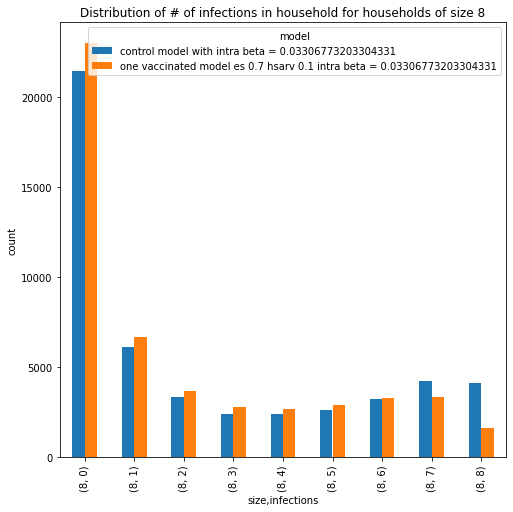

In [ ]:
# --- Run the study some number of times ---
trials = 1000
vax_df, control_df = one_vax_study.run_trials(trials, arms="both") # we collect the results of our study in two Pandas DataFrames. For more information see https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.html
utilities.make_bar_chart(pd.concat([vax_df, control_df])) # look at histograms of infections to check for coherence or interesting results

In [ ]:
# --- Analyze the results ---

vax_df

,size,model,infections,num vaccinated,vaccinated infected,unvaccinated infected,num unvaccinated,trialnum
0,8,one vaccinated model es 0.7 hsarv 0.1 intra be...,1,1.0,0,1,7.0,0
1,8,one vaccinated model es 0.7 hsarv 0.1 intra be...,5,1.0,0,5,7.0,0
2,8,one vaccinated model es 0.7 hsarv 0.1 intra be...,0,1.0,0,0,7.0,0
3,8,one vaccinated model es 0.7 hsarv 0.1 intra be...,5,1.0,0,5,7.0,0
4,8,one vaccinated model es 0.7 hsarv 0.1 intra be...,6,1.0,0,6,7.0,0
...,...,...,...,...,...,...,...,...
49995,8,one vaccinated model es 0.7 hsarv 0.1 intra be...,0,1.0,0,0,7.0,999
49996,8,one vaccinated model es 0.7 hsarv 0.1 intra be...,7,1.0,0,7,7.0,999
49997,8,one vaccinated model es 0.7 hsarv 0.1 intra be...,0,1.0,0,0,7.0,999
49998,8,one vaccinated model es 0.7 hsarv 0.1 intra be...,0,1.0,0,0,7.0,999


# Making a git commit from changes to python backend

To save this notebook use File > Save a copy in Github

In [ ]:
!git add -A
!git status

On branch main
Your branch is up to date with 'origin/main'.

nothing to commit, working tree clean


In [ ]:
!git config --global user.email ""
!git config --global user.email "Thayer"

In [ ]:
message = input("Commit message? ")

!git commit -m "{message}"

Commit message? Refactor filenames. Better behavior for modules
[main 6fdeff9] Refactor filenames. Better behavior for modules
 3 files changed, 22 insertions(+), 20 deletions(-)
 rename Likelihood.py => likelihood.py (97%)
 rename InfectionModel.py => population.py (90%)
 rename Vaccine.py => vaccine.py (94%)


# Pushing upstream

In [ ]:
!git remote set-url origin https://{git_token}@github.com/{repo_owner}/{repository}

In [ ]:
!git pull

Already up to date.


In [ ]:
#from git_token import git_token
#!git remote set-url origin https://{git_token}@github.com/{username}/{repository}

!git push